<a href="https://colab.research.google.com/github/kerenslendyrc/Estadistica/blob/main/Edpractica3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files # para cargar archivos en google colab
upload = files.upload()

Saving Base de datos.xlsx to Base de datos (1).xlsx


In [2]:
import pandas as pd
print(pd.__version__)
print(pd.__file__)

2.2.2
/usr/local/lib/python3.12/dist-packages/pandas/__init__.py


In [3]:
!pip install factor-analyzer

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity



In [5]:
import pandas as pd
import numpy as np
df = pd.read_excel("Base de datos.xlsx")

df_work = df.copy()

In [6]:
df["fallecimiento_SN"] = df["fecha_muerte"].notna().map({True: "SI", False: "NO"})

In [7]:
def capitulo_cie10(code):
    if pd.isna(code):
        return pd.NA
    c = str(code).strip()
    if len(c) == 0:
        return pd.NA
    return c[0]   # A, B, C, D, ...

df["capitulo_causa_muerte"] = df["cod_causa_basica_muerte"].apply(capitulo_cie10)


In [8]:
map_capitulos = {
    "A": "Infecciosas_parasitarias",
    "B": "Infecciosas_parasitarias",
    "C": "Neoplasias",
    "D": "Neoplasias_sangre",
    "E": "Endocrinas_nutricionales",
    "F": "Trastornos_mentales",
    "G": "Sistema_nervioso",
    "H": "Ojo_oido",
    "I": "Cardiovasculares",
    "J": "Respiratorias",
    "K": "Digestivas",
    "L": "Piel_tejido_subcutaneo",
    "M": "Musculoesqueleticas",
    "N": "Genitourinarias",
    "O": "Embarazo_parto_puerperio",
    "P": "Perinatales",
    "Q": "Malformaciones_congenitas",
    "R": "Sintomas_signos_mal_definidos",
    "S": "Traumatismos",
    "T": "Envenenamientos_y_otros_consec",
    "V": "Causas_externas_transporte",
    "W": "Causas_externas_otros",
    "X": "Causas_externas_otros2",
    "Y": "Causas_externas_otros3",
    "Z": "Factores_contacto_servicios",
}

# Rehacer la columna agrupada:
df["capitulo_causa_muerte"] = df["cod_causa_basica_muerte"].apply(capitulo_cie10)
df["grupo_causa_muerte"] = df["capitulo_causa_muerte"].map(map_capitulos)

# Si alguna letra no estaba en el diccionario, la mandas a "OTRO"
df["grupo_causa_muerte"] = df["grupo_causa_muerte"].fillna("OTRO")

# Ver ahora las categorías
df["grupo_causa_muerte"].value_counts()


,count
grupo_causa_muerte,
OTRO,138271
Neoplasias,682
Sintomas_signos_mal_definidos,615
Respiratorias,503
Cardiovasculares,346
Infecciosas_parasitarias,143
Digestivas,119
Neoplasias_sangre,90
Genitourinarias,74


In [9]:
# 1) Crear fallecimiento_SN si no lo tienes aún
df["fallecimiento_SN"] = df["fecha_muerte"].notna().map({True: "SI", False: "NO"})

# 2) Crear capítulo y grupo solo para quienes tienen código
df["capitulo_causa_muerte"] = df["cod_causa_basica_muerte"].apply(capitulo_cie10)

df["grupo_causa_muerte"] = df["capitulo_causa_muerte"].map(map_capitulos)

# 3) Diferenciar bien:
# - NO_APLICA si no falleció
# - OTRO solo si falleció pero la letra no está en el map_capitulos
df.loc[df["fallecimiento_SN"] == "NO", "grupo_causa_muerte"] = "NO_APLICA"
df.loc[
    (df["fallecimiento_SN"] == "SI") & (df["grupo_causa_muerte"].isna()),
    "grupo_causa_muerte"
] = "OTRO"

df["grupo_causa_muerte"].value_counts()


,count
grupo_causa_muerte,
NO_APLICA,138098
Neoplasias,681
Sintomas_signos_mal_definidos,615
Respiratorias,502
Cardiovasculares,346
OTRO,175
Infecciosas_parasitarias,143
Digestivas,119
Neoplasias_sangre,90


In [10]:
def agrupar_uo_medico_macro(uo):
    if pd.isna(uo):
        return "OTRA"
    u = str(uo).upper()

    # Cuidados intensivos
    if "INTEN" in u:  # 1MHINTEN
        return "UCI"

    # Pediatría
    if "PEDIA" in u or "CXPED" in u or "ORTPE" in u or "NEONA" in u or "ORPED" in u or "OFPED" in u:
        return "PEDIATRIA"

    # Ginecología / Obstetricia
    if "GINEC" in u or "GINEO" in u or "CACUE" in u:  # CACUE lo mando a gineco-onco
        return "GINECOLOGIA"

    # Medicina Interna
    if "MEINT" in u:
        return "MEDICINA_INTERNA"

    # Cirugía (general y subespecialidades CX***, COLOP, etc.)
    if "CX" in u or "COLOP" in u:
        return "CIRUGIA"

    # Urología
    if "UROLO" in u or "UROLP" in u or "URONC" in u:
        return "UROLOGIA"

    # Hematología / Hemato-oncología
    if "HEMAT" in u or "HEMTR" in u or "HEONP" in u or "HE-ON" in u or "HEMAP" in u:
        return "HEMATOLOGIA_ONCO"

    # Oncología (códigos ONCO específicos)
    if "ONCOL" in u or "ONCOP" in u or "CXONC" in u or "ORON" in u:
        return "ONCOLOGIA"

    # Oftalmología
    if "OFTAL" in u or "OFPLA" in u or "RETIN" in u or "OFPED" in u or "NEUOF" in u:
        return "OFTALMOLOGIA"

    # Neurología
    if "NEURO" in u or "NEURP" in u:
        return "NEUROLOGIA"

    # Nefrología
    if "NEFRO" in u or "NEFTR" in u or "NEFRP" in u:
        return "NEFROLOGIA"

    # Ortopedia
    if "ORTOP" in u or "ORTOD" in u:
        return "ORTOPEDIA"

    # Alergia
    if "ALERG" in u:
        return "ALERGOLOGIA"

    # Geriatría
    if "GERIA" in u:
        return "GERIATRIA"

    # Cardiología
    if "CARDI" in u:
        return "CARDIOLOGIA"

    # Gastroenterología
    if "GASTR" in u or "GASTP" in u:
        return "GASTROENTEROLOGIA"

    # Otorrino
    if "OTORR" in u or "OTOLO" in u:
        return "OTORRINOLARINGOLOGIA"

    # Imagen/diagnóstico (radiología, med nuclear, laboratorio especial)
    if "RADIN" in u or "RADIO" in u or "MENUC" in u or "MELAB" in u:
        return "IMAGENOLOGIA"

    # Reumatología
    if "REUMA" in u or "REUMP" in u:
        return "REUMATOLOGIA"

    # Endocrinología
    if "ENDOC" in u:
        return "ENDOCRINOLOGIA"

    # Urgencias
    if "URGEN" in u:
        return "URGENCIAS"

    # Anestesiología
    if "ANECL" in u:
        return "ANESTESIOLOGIA"

    return "OTRA"

# Recalcular la macro-categoría
df["uo_medico_macro"] = df["uo_medico"].apply(agrupar_uo_medico_macro)

# Ver cómo queda ahora la distribución
df["uo_medico_macro"].value_counts()


,count
uo_medico_macro,
MEDICINA_INTERNA,54633
GINECOLOGIA,30799
PEDIATRIA,17409
CIRUGIA,15668
HEMATOLOGIA_ONCO,6746
UROLOGIA,4853
ORTOPEDIA,3865
ANESTESIOLOGIA,2861
URGENCIAS,1205


In [11]:
df.loc[df["uo_medico_macro"] == "OTRA", "uo_medico"].value_counts().head(20)


,count
uo_medico,
1MHPERIN,6
1MHINFEC,5
1MHANDRO,4
1MHCARDP,3
1MHCARIN,3
1MHINTEP,2
1MHOFCOR,2
1MHOFSEG,2
1MHNEUMO,1


In [12]:
# Ver las unidades más frecuentes
vc_uo = df["id_discapacidad"].value_counts()
top_uo = vc_uo.head(50).index   # por ejemplo, las 20 más frecuentes

# Crear grupo: top unidades vs resto
df["id_discapacidad_top"] = df["id_discapacidad"].where(df["id_discapacidad"].isin(top_uo), "OTRAS_UNIDADES")

df["id_discapacidad_top"].value_counts()


,count
id_discapacidad_top,
Ninguna,103486
OTRAS_UNIDADES,27745
Movimiento cuerpo extremidades,3277
El sistema nervioso,1457
Cardiorespiratorio y/o defensas,1278
"El sistema nervioso, Movimiento cuerpo extremidades",831
Los ojos,668
Los oÃ­dos,308
RENAL,298


In [13]:
def agrupar_discapacidad_macro(desc):
    # 1) Faltantes o punto suelto
    if pd.isna(desc):
        return "DESCONOCIDA"
    s = str(desc).upper().strip()

    # 2) Sin discapacidad
    if "NINGUNA" in s or s == "NINGUNA" or "NO APLICA" in s:
        return "SIN_DISCAPACIDAD"

    # 3) Preparamos flags por sistema / tipo
    grupos = []

    # Motora / aparato locomotor
    if "MOVIMIENTO CUERPO" in s or "EXTREMIDADES" in s:
        grupos.append("MOTORA")
    if "ÓSEA" in s or "Ã“SEA" in s or "OSEA" in s:
        grupos.append("MOTORA")

    # Neurológica / cognitiva
    if "SISTEMA NERVIOSO" in s or "DEMENCIA" in s:
        grupos.append("NEUROLOGICA")

    # Cardiorrespiratorio y defensas
    if "CARDIORRESPIRATORIO" in s or "CARDIORESPIRATORIO" in s or "DEFENSAS" in s:
        grupos.append("CARDIORESPIRATORIA_DEFENSAS")

    # Sensorial visual
    if "LOS OJOS" in s or "OJOS" in s:
        grupos.append("SENSORIAL_VISUAL")

    # Sensorial auditiva (ojo con caracteres raros)
    if "LOS OÍDOS" in s or "LOS OIDOS" in s or "LOS OÃDOS" in s or "OÍDOS" in s or "OIDOS" in s or "OÃDOS" in s:
        grupos.append("SENSORIAL_AUDITIVA")

    # Comunicación (voz y habla)
    if "VOZ" in s or "HABLA" in s:
        grupos.append("COMUNICACION")

    # Renal
    if "RENAL" in s:
        grupos.append("RENAL")

    # Metabólica / endocrina / digestiva
    if "DIGESTI" in s or "METABOL" in s or "HORMONAL" in s or "OBESIDAD" in s or "ENDOCR" in s:
        grupos.append("METABOLICA_ENDOCRINA")

    # Piel
    if "LA PIEL" in s or "PIEL" in s:
        grupos.append("PIEL")

    # Genital / reproductivo
    if "GENITAL" in s or "REPRODUCTIVO" in s:
        grupos.append("GENITAL_REPRODUCTIVO")

    # Inmunidad / hematológica / onco-hemato
    if "INMUNIDAD" in s or "HEMATOLOGICA" in s or "CITOPENIAS" in s or "HODGKIN" in s:
        grupos.append("INMUNO_HEMATOLOGICA")

    # 4) Si tiene varias áreas a la vez → MULTIPLE
    grupos_unicos = list(set(grupos))

    if len(grupos_unicos) == 0:
        # Casos especiales que son más bien diagnósticos pero los tiramos a INMUNO/HEMATO o OTRA
        if "CA DE MAMA" in s or "MAMA" in s:
            return "INMUNO_HEMATOLOGICA"
        if "QUIMIOTERAPIA" in s:
            return "INMUNO_HEMATOLOGICA"
        if "EDAD" in s:
            return "MOTORA"   # fragilidad asociada a edad, si quieres puedes crear una categoría aparte
        if "OTRAS_UNIDADES" in s or s == ".":
            return "OTRA"
        # Nada matchea → OTRA
        return "OTRA"

    if len(grupos_unicos) == 1:
        return grupos_unicos[0]

    # Si tiene más de un sistema comprometido
    return "MULTIPLE"


# Aplicar sobre la columna de texto de discapacidad
df["tipo_discapacidad_macro"] = df["id_discapacidad_top"].apply(agrupar_discapacidad_macro)

# Ver cómo quedó
df["tipo_discapacidad_macro"].value_counts()


,count
tipo_discapacidad_macro,
SIN_DISCAPACIDAD,103591
OTRA,28118
MOTORA,3443
MULTIPLE,1585
NEUROLOGICA,1476
CARDIORESPIRATORIA_DEFENSAS,1278
SENSORIAL_VISUAL,704
RENAL,332
METABOLICA_ENDOCRINA,232


In [14]:
df.loc[df["tipo_discapacidad_macro"] == "OTRA", "id_discapacidad_top"] \
  .value_counts() \
  .head(30)


,count
id_discapacidad_top,
OTRAS_UNIDADES,27745
Los oÃ­dos,308
.,41
Olfato tacto y/o gusto,24


In [15]:
# 1) Los oídos → sensorial auditiva
mask_oidos = df["id_discapacidad_top"].str.contains("Los oÃ­dos", case=False, na=False)
df.loc[mask_oidos, "tipo_discapacidad_macro"] = "SENSORIAL_AUDITIVA"

# 2) Olfato tacto y/o gusto → sensorial otros
mask_olfato = df["id_discapacidad_top"].str.contains("Olfato tacto y/o gusto", case=False, na=False)
df.loc[mask_olfato, "tipo_discapacidad_macro"] = "SENSORIAL_OTROS"

# 3) Si quieres separar el punto como DESCONOCIDA
mask_punto = df["id_discapacidad_top"].eq(".")
df.loc[mask_punto, "tipo_discapacidad_macro"] = "DESCONOCIDA"

# Ver cómo queda
df["tipo_discapacidad_macro"].value_counts()


,count
tipo_discapacidad_macro,
SIN_DISCAPACIDAD,103533
OTRA,27745
MOTORA,3348
MULTIPLE,1585
NEUROLOGICA,1476
CARDIORESPIRATORIA_DEFENSAS,1278
SENSORIAL_VISUAL,668
SENSORIAL_AUDITIVA,522
RENAL,332


In [16]:
import numpy as np
import pandas as pd

# 1) Estandarizar nombres de ciudad y departamento
df['ciudad_clean'] = (
    df['ciudad']
    .astype(str)
    .str.strip()
    .str.upper()
)

df['departamento_clean'] = (
    df['departamento']
    .astype(str)
    .str.strip()
    .str.upper()
)

# 2) Diccionario municipio -> provincia (solo SANTANDER)
provincia_map = {
    # --- METROPOLITANA ---
    'BUCARAMANGA': 'Metropolitana',
    'FLORIDABLANCA': 'Metropolitana',
    'GIRÓN': 'Metropolitana',
    'GIRON': 'Metropolitana',        # por si viene sin tilde
    'PIEDECUESTA': 'Metropolitana',
    'LEBRIJA': 'Metropolitana',
    'LOS SANTOS': 'Metropolitana',
    'RIONEGRO': 'Metropolitana',
    'SANTA BÁRBARA': 'Metropolitana',
    'SANTA BARBARA': 'Metropolitana',
    'ZAPATOCA': 'Metropolitana',
    'EL PLAYÓN': 'Metropolitana',
    'EL PLAYON': 'Metropolitana',
    # Decide tú si TONA va aquí o en Soto Norte:
    'TONA': 'Metropolitana',

    # --- COMUNERA ---
    'CHIMA': 'Comunera',
    'CONFINES': 'Comunera',
    'CONTRATACIÓN': 'Comunera',
    'CONTRATACION': 'Comunera',
    'EL GUACAMAYO': 'Comunera',
    'GALÁN': 'Comunera',
    'GALAN': 'Comunera',
    'GÁMBITA': 'Comunera',
    'GAMBITA': 'Comunera',
    'GUADALUPE': 'Comunera',
    'GUAPOTÁ': 'Comunera',
    'GUAPOTA': 'Comunera',
    'HATO': 'Comunera',
    'OIBA': 'Comunera',
    'PALMAR': 'Comunera',
    'PALMAS DEL SOCORRO': 'Comunera',
    'SANTA HELENA DEL OPÓN': 'Comunera',
    'SANTA HELENA DEL OPON': 'Comunera',
    'SIMACOTA': 'Comunera',
    'SOCORRO': 'Comunera',
    'SUAITA': 'Comunera',

    # --- VÉLEZ ---
    'AGUADA': 'Vélez',
    'ALBANIA': 'Vélez',
    'BARBOSA': 'Vélez',
    'BOLÍVAR': 'Vélez',
    'BOLIVAR': 'Vélez',
    'CHIPATÁ': 'Vélez',
    'CHIPATA': 'Vélez',
    'CIMITARRA': 'Vélez',
    'EL PEÑÓN': 'Vélez',
    'EL PENON': 'Vélez',
    'FLORIÁN': 'Vélez',
    'FLORIAN': 'Vélez',
    'GUAVATÁ': 'Vélez',
    'GUAVATA': 'Vélez',
    'GÜEPSA': 'Vélez',
    'GUEPSA': 'Vélez',
    'JESÚS MARÍA': 'Vélez',
    'JESUS MARIA': 'Vélez',
    'LA BELLEZA': 'Vélez',
    'LA PAZ': 'Vélez',
    'LANDÁZURI': 'Vélez',
    'LANDAZURI': 'Vélez',
    'PUENTE NACIONAL': 'Vélez',
    'PUERTO PARRA': 'Vélez',
    'SAN BENITO': 'Vélez',
    'SUAREZ': 'Vélez',   # si apareciera así en tus datos
    'SUCRE': 'Vélez',
    'VÉLEZ': 'Vélez',
    'VELEZ': 'Vélez',

    # --- GUANENTÁ ---
    'ARATOCA': 'Guanentá',
    'BARICHARA': 'Guanentá',
    'CABRERA': 'Guanentá',
    'CHARALÁ': 'Guanentá',
    'CHARALA': 'Guanentá',
    'COROMORO': 'Guanentá',
    'CURITÍ': 'Guanentá',
    'CURITI': 'Guanentá',
    'ENCINO': 'Guanentá',
    'JORDÁN': 'Guanentá',
    'JORDAN': 'Guanentá',
    'MOGOTES': 'Guanentá',
    'OCAMONTE': 'Guanentá',
    'ONZAGA': 'Guanentá',
    'PÁRAMO': 'Guanentá',
    'PARAMO': 'Guanentá',
    'PINCHOTE': 'Guanentá',
    'SAN GIL': 'Guanentá',
    'SAN JOAQUÍN': 'Guanentá',
    'SAN JOAQUIN': 'Guanentá',
    'VALLE DE SAN JOSÉ': 'Guanentá',
    'VALLE DE SAN JOSE': 'Guanentá',
    'VILLANUEVA': 'Guanentá',

    # --- GARCÍA ROVIRA ---
    'CAPITANEJO': 'García Rovira',
    'CARCASÍ': 'García Rovira',
    'CARCASI': 'García Rovira',
    'CEPITÁ': 'García Rovira',
    'CEPITA': 'García Rovira',
    'CERRITO': 'García Rovira',
    'CONCEPCIÓN': 'García Rovira',
    'CONCEPCION': 'García Rovira',
    'ENCISO': 'García Rovira',
    'GUACA': 'García Rovira',
    'MACARAVITA': 'García Rovira',
    'MÁLAGA': 'García Rovira',
    'MALAGA': 'García Rovira',
    'MOLAGAVITA': 'García Rovira',
    'SAN ANDRÉS': 'García Rovira',
    'SAN ANDRES': 'García Rovira',
    'SAN JOSÉ DE MIRANDA': 'García Rovira',
    'SAN JOSE DE MIRANDA': 'García Rovira',
    'SAN MIGUEL': 'García Rovira',

    # --- YARIGUÍES ---
    'BARRANCABERMEJA': 'Yariguíes',
    'BETULIA': 'Yariguíes',
    'EL CARMEN DE CHUCURÍ': 'Yariguíes',
    'EL CARMEN DE CHUCURI': 'Yariguíes',
    'PUERTO WILCHES': 'Yariguíes',
    'SABANA DE TORRES': 'Yariguíes',
    'SAN VICENTE DE CHUCURÍ': 'Yariguíes',
    'SAN VICENTE DE CHUCURI': 'Yariguíes',

    # --- SOTO / SOTO NORTE ---
    'CALIFORNIA': 'Soto Norte',
    'CHARTA': 'Soto Norte',
    'MATANZA': 'Soto Norte',
    'SURATÁ': 'Soto Norte',
    'SURATA': 'Soto Norte',
    'VETAS': 'Soto Norte',
    # Si prefieres que Tona quede aquí:
    # 'TONA': 'Soto Norte',
}

# 3) Crear la variable provincia_ciudad para SANTANDER
df['provincia_ciudad'] = df['ciudad_clean'].map(provincia_map)

# 4) Asignar 'Otros departamentos' para todo lo que no es Santander
df.loc[df['departamento_clean'] != 'SANTANDER', 'provincia_ciudad'] = 'Otros departamentos'

# 5) Cualquier municipio de Santander no mapeado explícitamente también va a 'Otros departamentos'
df['provincia_ciudad'] = df['provincia_ciudad'].fillna('Otros departamentos')

# Opcional: revisar distribución
print(df['provincia_ciudad'].value_counts(dropna=False))


provincia_ciudad
Metropolitana          116917
Otros departamentos      9042
Yariguíes                6759
Guanentá                 3751
Vélez                    1832
Comunera                 1432
García Rovira             852
Soto Norte                570
Name: count, dtype: int64


In [17]:
eps_counts = df['EPS'].value_counts(dropna=False)
print(eps_counts.head(30))


EPS
NUEVA EPS                        103886
FIDUPREVISORA                     12194
ECOPETROL                          4694
EPS SANITAS                        3975
COLSANITAS                         1884
EPS FAMISANAR                      1728
SURAMERICANA SA                    1693
CLINICA SANTA CRUZ DE LA LOMA      1446
COOSALUD EPS                       1269
AXA COLPATRIA                      1216
SALUD TOTAL EPS                     795
ALLIANZ SEGUROS                     720
MEDISANITAS                         623
COLMEDICA MEDICINA PREPAGADA        537
COOMEVA EPS                         439
UIS                                 397
SEGUROS BOLIVAR                     360
PACIENTE PARTICULAR                 288
SALUD TOTAL SUBSIADO                250
HDI SEGUROS (ANTES LIBERTY)         224
MED PLUS MEDICINA PREPAGADA         212
COMPENSAR EPS                       198
CORSO SALAMANCA JAIRO               183
FUNDACION MEDICO PREVENTIVA         169
COMPAÃ‘IA MUNDIAL DE SEGUROS        

In [18]:
# 1) Limpieza básica
df['EPS_clean'] = (
    df['EPS']
    .astype(str)
    .str.strip()
    .str.upper()
)

# 2) Unificar TODAS las variantes que contengan "NUEVA EPS"
mask_nueva = df['EPS_clean'].str.contains('NUEVA EPS', na=False)
df.loc[mask_nueva, 'EPS_clean'] = 'NUEVA EPS'

# 3) Recalcular frecuencias sobre la columna ya unificada
eps_freq = df['EPS_clean'].value_counts(normalize=True)

umbral_grande = 0.05
umbral_mediana_inf = 0.01

def clasificar_eps(eps):
    if pd.isna(eps):
        return 'EPS_no_reportada'
    if eps == 'NUEVA EPS':
        return 'EPS_NUEVA'
    f = eps_freq.get(eps, 0)
    if f >= umbral_grande:
        return 'EPS_grandes'
    elif f >= umbral_mediana_inf:
        return 'EPS_medianas'
    else:
        return 'EPS_pequeñas'

df['EPS_grupo'] = df['EPS_clean'].apply(clasificar_eps)

print(df.loc[df['EPS_clean'] == 'NUEVA EPS', 'EPS_grupo'].value_counts())


EPS_grupo
EPS_NUEVA    103887
Name: count, dtype: int64


In [19]:
# Ver todas las variantes que contienen "NUEVA EPS"
mask_nueva = df['EPS_clean'].str.contains('NUEVA EPS', na=False)

print(df.loc[mask_nueva, 'EPS_clean'].value_counts())
print(df.loc[mask_nueva, 'EPS_grupo'].value_counts())


EPS_clean
NUEVA EPS    103887
Name: count, dtype: int64
EPS_grupo
EPS_NUEVA    103887
Name: count, dtype: int64


In [20]:
import pandas as pd

# Tabla con EPS limpia, grupo y frecuencia absoluta
tabla_eps = (
    df
    .groupby(['EPS_grupo', 'EPS_clean'])
    .size()
    .reset_index(name='n_pacientes')
    .sort_values(['EPS_grupo', 'n_pacientes'], ascending=[True, False])
)

print("=== EPS por grupo (con número de pacientes) ===")
print(tabla_eps)

# Si quieres ver solo los nombres de EPS por grupo:
eps_por_grupo = (
    tabla_eps
    .groupby('EPS_grupo')['EPS_clean']
    .apply(list)
)

print("\n=== Listado de EPS en cada grupo ===")
for grupo, lista_eps in eps_por_grupo.items():
    print(f"\nGrupo: {grupo}")
    for eps in lista_eps:
        print(f"  - {eps}")


=== EPS por grupo (con número de pacientes) ===
       EPS_grupo                   EPS_clean  n_pacientes
0      EPS_NUEVA                   NUEVA EPS       103887
1    EPS_grandes               FIDUPREVISORA        12194
4   EPS_medianas                   ECOPETROL         4694
6   EPS_medianas                 EPS SANITAS         3975
3   EPS_medianas                  COLSANITAS         1884
..           ...                         ...          ...
53  EPS_pequeñas  LA Â CLINIC Â DU CORPS LTD            1
78  EPS_pequeñas   TRAVEL GUARD AMERICAS LLC            1
80  EPS_pequeñas                      UNACSA            1
83  EPS_pequeñas    UNION TEMPORAL TOLIHUILA            1
86  EPS_pequeñas        YEPES PEREZ HERNANDO            1

[87 rows x 3 columns]

=== Listado de EPS en cada grupo ===

Grupo: EPS_NUEVA
  - NUEVA EPS

Grupo: EPS_grandes
  - FIDUPREVISORA

Grupo: EPS_medianas
  - ECOPETROL
  - EPS SANITAS
  - COLSANITAS
  - EPS FAMISANAR
  - SURAMERICANA SA
  - CLINICA SANTA CRU

In [21]:
# 2) Columnas categóricas que sí vamos a convertir en dummies
cols_a_dummificar = [
    "provincia_ciudad",
    "Servicio",
    "asignacion_enfermeria",
    "gran_causa_morbilidad",
    "uo_medico_macro",
    "sexo",
    "EPS_grupo",
    "tipo_discapacidad_macro",
    "fallecimiento_SN"   # SÍ / NO
]

# Por seguridad: nos quedamos solo con las que realmente existan en df
cols_existentes = [c for c in cols_a_dummificar if c in df.columns]
cols_faltantes = [c for c in cols_a_dummificar if c not in df.columns]

print("Dummificando columnas:", cols_existentes)
print("No se encontraron en df:", cols_faltantes)


Dummificando columnas: ['provincia_ciudad', 'Servicio', 'asignacion_enfermeria', 'gran_causa_morbilidad', 'uo_medico_macro', 'sexo', 'EPS_grupo', 'tipo_discapacidad_macro', 'fallecimiento_SN']
No se encontraron en df: []


In [22]:
cols_cardinalidad = [
    "provincia_ciudad",
    "Servicio",
    "asignacion_enfermeria",
    "gran_causa_morbilidad",
    "uo_medico_macro",
    "sexo",
    "EPS_grupo",
    "tipo_discapacidad_macro",
    "fallecimiento_SN"
]

print("=== Cardinalidad de variables categóricas ===\n")

resumen = []
for col in cols_cardinalidad:
    n_cat = df[col].nunique(dropna=True)
    resumen.append({"variable": col, "n_categorias": n_cat})

    print(f"Variable: {col}")
    print(f" - Número de categorías: {n_cat}")
    print(" - Top 10 categorías más frecuentes:")
    print(df[col].value_counts(dropna=False).head(10))
    print("\n" + "-"*60 + "\n")


=== Cardinalidad de variables categóricas ===

Variable: provincia_ciudad
 - Número de categorías: 8
 - Top 10 categorías más frecuentes:
provincia_ciudad
Metropolitana          116917
Otros departamentos      9042
Yariguíes                6759
Guanentá                 3751
Vélez                    1832
Comunera                 1432
García Rovira             852
Soto Norte                570
Name: count, dtype: int64

------------------------------------------------------------

Variable: Servicio
 - Número de categorías: 5
 - Top 10 categorías más frecuentes:
Servicio
Hospitalización adultos       95766
Ginecobstetricia              22748
Hospitalización pediatrica    18748
UCI Adultos                    2980
UCI Pediatrica                  913
Name: count, dtype: int64

------------------------------------------------------------

Variable: asignacion_enfermeria
 - Número de categorías: 28
 - Top 10 categorías más frecuentes:
asignacion_enfermeria
1 UE HOSP URGENCIAS CAL P5        42

In [23]:
# 3) Dummies 0/1 para las columnas categóricas
df_dummies = pd.get_dummies(
    df[cols_existentes],
    columns=cols_existentes,
    drop_first=False,   # conserva todas las categorías (útil para análisis descriptivo)
    dtype=int
)

# 4) Construir un DataFrame final mezclando edad + dummies
X_dummis = pd.concat(
    [
        df[["edad"]].reset_index(drop=True),  # edad numérica
        df_dummies.reset_index(drop=True)
    ],
    axis=1
)

X_dummis.head()


,edad,provincia_ciudad_Comunera,provincia_ciudad_García Rovira,provincia_ciudad_Guanentá,provincia_ciudad_Metropolitana,provincia_ciudad_Otros departamentos,provincia_ciudad_Soto Norte,provincia_ciudad_Vélez,provincia_ciudad_Yariguíes,Servicio_Ginecobstetricia,...,tipo_discapacidad_macro_NEUROLOGICA,tipo_discapacidad_macro_OTRA,tipo_discapacidad_macro_PIEL,tipo_discapacidad_macro_RENAL,tipo_discapacidad_macro_SENSORIAL_AUDITIVA,tipo_discapacidad_macro_SENSORIAL_OTROS,tipo_discapacidad_macro_SENSORIAL_VISUAL,tipo_discapacidad_macro_SIN_DISCAPACIDAD,fallecimiento_SN_NO,fallecimiento_SN_SI
0,31,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,77,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,76,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,67,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,67,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [24]:
# 1) Matriz de entrada para PCA
X = X_dummis.copy()
features = X.columns

# 2) Estandarización (media 0, varianza 1)
scaler = StandardScaler(with_mean=True, with_std=True)
X_scaled = scaler.fit_transform(X)


In [25]:
from sklearn.decomposition import PCA
import numpy as np

# X_scaled es tu matriz estandarizada (la que ya tenías)
n_muestras = min(30000, X_scaled.shape[0])  # por ejemplo, máximo 30k filas
idx = np.random.choice(X_scaled.shape[0], size=n_muestras, replace=False)
X_sample = X_scaled[idx]

# PCA que elige automáticamente los componentes para explicar el 85% de la varianza
pca_sample = PCA(
    n_components=0.85,      # queremos ≥ 85% de varianza
    svd_solver="full",      # obligatorio para usar float como n_components
    random_state=0
)

X_pca_sample = pca_sample.fit_transform(X_sample)

# Número de componentes que alcanzan ≥85% en la muestra
n_components_85 = pca_sample.n_components_
print("Componentes necesarios (muestra) para ≥85% varianza:", n_components_85)

# Si quieres ver la varianza acumulada en la muestra:
explained_var_sample = pca_sample.explained_variance_ratio_
cum_var_sample = np.cumsum(explained_var_sample)
print("Varianza acumulada en la muestra:", cum_var_sample)



Componentes necesarios (muestra) para ≥85% varianza: 61
Varianza acumulada en la muestra: [0.05566102 0.09046828 0.11829459 0.1442974  0.16806092 0.18922926
 0.20961781 0.22967105 0.24809868 0.26628154 0.28310996 0.29943309
 0.3153882  0.33128461 0.3469087  0.36186015 0.37660784 0.39047137
 0.40410061 0.4175053  0.43074189 0.44393093 0.45686466 0.46913398
 0.48122164 0.49321817 0.50502886 0.51670523 0.52830308 0.53957169
 0.550771   0.56189765 0.57287956 0.58383902 0.59474054 0.60558221
 0.61628222 0.62695091 0.63756358 0.64809131 0.65859509 0.66904307
 0.67940587 0.68974413 0.70004375 0.71033598 0.7205785  0.73065161
 0.74070101 0.75061398 0.76044538 0.7702417  0.77998066 0.78964986
 0.79928603 0.80882755 0.81835999 0.8278475  0.83727594 0.84655956
 0.85580271]


In [26]:
# Supón que tienes pca y explained_variance_ratio_
var_acum = pca_sample.explained_variance_ratio_.cumsum()
for k in [10, 20, 30, 40]:
    print(k, var_acum[k-1])


10 0.26628154454082653
20 0.4175052988970277
30 0.5395716874471688
40 0.6480913089236664


In [27]:
# Después de:
# X_pca_sample = pca_sample.fit_transform(X_sample)

# 1) Proyectar TODO X_scaled al espacio PCA
X_pca = pca_sample.transform(X_scaled)   # <- AQUÍ creas X_pca

print("Shape X_pca:", X_pca.shape)  # debería ser (n_obs, n_components_85)

# 2) Ahora sí puedes usar el código de HDBSCAN que te pasé
n_muestras_hdb = min(30000, X_pca.shape[0])  # para exploración inicial
idx_hdb = np.random.choice(X_pca.shape[0], size=n_muestras_hdb, replace=False)
X_hdb = X_pca[idx_hdb]


Shape X_pca: (141155, 61)


In [28]:
import numpy as np

# X_pca: matriz (n_obs, n_comp) ya calculada
n_muestras_hdb = min(10000, X_pca.shape[0])  # para exploración inicial
idx_hdb = np.random.choice(X_pca.shape[0], size=n_muestras_hdb, replace=False)
X_hdb = X_pca[idx_hdb]


HBDSCAN

In [29]:
pip install hdbscan


In [30]:
import hdbscan
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score


In [31]:
import numpy as np
import pandas as pd
import hdbscan
from sklearn.metrics import silhouette_score

param_grid = [
    # min_cluster_size, min_samples
    (300, 10),
    (300, 30),
    (500, 10),
    (500, 30),
    (800, 20),
    (1000, 30),
]

resultados = []

# límite de puntos para calcular silhouette
max_sil_samples = 3000

for min_cs, min_s in param_grid:
    print(f"\nProbando HDBSCAN (min_cluster_size={min_cs}, min_samples={min_s})")

    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cs,
        min_samples=min_s,
        metric='euclidean',
        cluster_selection_method='eom',
        core_dist_n_jobs=-1   # usa todos los cores para distancias núcleo
    )

    labels = clusterer.fit_predict(X_hdb)

    # -1 es ruido
    mask_core = labels != -1
    n_clusters = len(set(labels[mask_core]))
    prop_ruido = 1.0 - mask_core.mean()

    # Cálculo de silhouette sólo si tiene sentido
    if n_clusters >= 2 and mask_core.sum() > 10:
        idx_core = np.where(mask_core)[0]

        # Submuestras para el silhouette
        if idx_core.size > max_sil_samples:
            idx_core = np.random.choice(idx_core, size=max_sil_samples, replace=False)

        sil = silhouette_score(X_hdb[idx_core], labels[idx_core])
    else:
        sil = np.nan

    resultados.append({
        "min_cluster_size": min_cs,
        "min_samples": min_s,
        "n_clusters": n_clusters,
        "prop_ruido": prop_ruido,
        "silhouette": sil
    })

resultados_hdb = pd.DataFrame(resultados)
print(resultados_hdb)



Probando HDBSCAN (min_cluster_size=300, min_samples=10)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Probando HDBSCAN (min_cluster_size=300, min_samples=30)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Probando HDBSCAN (min_cluster_size=500, min_samples=10)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Probando HDBSCAN (min_cluster_size=500, min_samples=30)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Probando HDBSCAN (min_cluster_size=800, min_samples=20)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Probando HDBSCAN (min_cluster_size=1000, min_samples=30)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


   min_cluster_size  min_samples  n_clusters  prop_ruido  silhouette
0               300           10           6      0.6339    0.294077
1               300           30           5      0.6883    0.348466
2               500           10           3      0.7530    0.331522
3               500           30           3      0.7710    0.355877
4               800           20           2      0.7611    0.221951
5              1000           30           0      1.0000         NaN


sí hay grupos densos interesantes, pero son una minoría de los episodios; la mayoría viven en zonas de densidad intermedia que yo prefiero llamar ‘ruido’

In [36]:
# Elige una config, por ejemplo esta:
min_cluster_size = 500
min_samples = 30

clusterer_best = hdbscan.HDBSCAN(
    min_cluster_size=min_cluster_size,
    min_samples=min_samples,
    metric='euclidean',
    cluster_selection_method='eom'
)

labels_best = clusterer_best.fit_predict(X_hdb)
pd.Series(labels_best).value_counts()


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,count
-1,7710
1,918
0,807
2,565


In [37]:

df_work["cluster_HDBSCAN"] = -1     # valor por defecto

df_work.loc[df_work.index[idx_hdb], "cluster_HDBSCAN"] = labels_best
df_work["cluster_HDBSCAN"] = df_work["cluster_HDBSCAN"].astype(int)

print(df_work["cluster_HDBSCAN"].value_counts())


cluster_HDBSCAN
-1    138865
 1       918
 0       807
 2       565
Name: count, dtype: int64


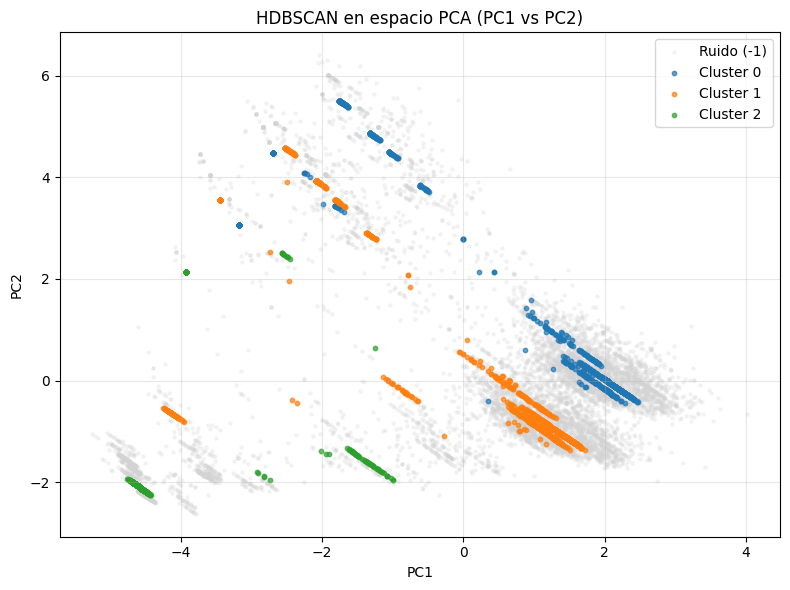

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Máscara de ruido y de puntos en clúster
mask_noise = (labels_best == -1)
mask_cluster = (labels_best != -1)

plt.figure(figsize=(8, 6))

# Ruido en gris clarito
plt.scatter(
    X_hdb[mask_noise, 0], X_hdb[mask_noise, 1],
    s=5, alpha=0.2, label="Ruido (-1)", color="lightgray"
)

# Clústeres con colores diferentes
for cl in sorted(np.unique(labels_best[mask_cluster])):
    mask = (labels_best == cl)
    plt.scatter(
        X_hdb[mask, 0], X_hdb[mask, 1],
        s=10, alpha=0.7, label=f"Cluster {cl}"
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("HDBSCAN en espacio PCA (PC1 vs PC2)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


En todas las tablas, prop es la proporción dentro del clúster, es decir:

De todos los pacientes del clúster k, ¿qué porcentaje pertenece a este servicio / grupo de edad / causa?

No es proporción sobre toda la base, sino dentro de cada clúster.

In [40]:
tabla_serv_hdb = (
    df_work[df_work["cluster_HDBSCAN"] >= 0]  # solo clústeres, sin ruido
    .groupby(["cluster_HDBSCAN", "Servicio"])
    .size()
    .reset_index(name="n")
)

tabla_serv_hdb["prop"] = (
    tabla_serv_hdb.groupby("cluster_HDBSCAN")["n"]
    .transform(lambda x: x / x.sum())
)

# Ver los top servicios por clúster
tabla_serv_hdb.sort_values(["cluster_HDBSCAN", "prop"], ascending=[True, False]).groupby(
    "cluster_HDBSCAN"
).head(5)


,cluster_HDBSCAN,Servicio,n,prop
0,0,Hospitalización adultos,593,0.734820
1,0,Hospitalización pediatrica,214,0.265180
3,1,Hospitalización adultos,671,0.730937
4,1,Hospitalización pediatrica,189,0.205882
2,1,Ginecobstetricia,58,0.063181
5,2,Ginecobstetricia,472,0.835398
6,2,Hospitalización adultos,61,0.107965
7,2,Hospitalización pediatrica,32,0.056637


In [41]:
tabla_edad_hdb = (
    df_work[df_work["cluster_HDBSCAN"] >= 0]
    .groupby(["cluster_HDBSCAN", "grupo_de_edad"])
    .size()
    .reset_index(name="n")
)

tabla_edad_hdb["prop"] = (
    tabla_edad_hdb.groupby("cluster_HDBSCAN")["n"]
    .transform(lambda x: x / x.sum())
)

tabla_edad_hdb.sort_values(["cluster_HDBSCAN", "prop"], ascending=[True, False]).groupby(
    "cluster_HDBSCAN"
).head(5)


,cluster_HDBSCAN,grupo_de_edad,n,prop
16,0,80 Y MÁS,141,0.174721
0,0,0-4,137,0.169765
15,0,75-79,84,0.104089
14,0,70-74,69,0.085502
12,0,60-64,57,0.070632
33,1,80 Y MÁS,165,0.179739
17,1,0-4,126,0.137255
32,1,75-79,85,0.092593
31,1,70-74,62,0.067538
30,1,65-69,53,0.057734


In [42]:
tabla_diag_hdb = (
    df_work[df_work["cluster_HDBSCAN"] >= 0]
    .groupby(["cluster_HDBSCAN", "gran_causa_morbilidad"])
    .size()
    .reset_index(name="n")
)

tabla_diag_hdb["prop"] = (
    tabla_diag_hdb.groupby("cluster_HDBSCAN")["n"]
    .transform(lambda x: x / x.sum())
)

tabla_diag_hdb.sort_values(["cluster_HDBSCAN", "prop"], ascending=[True, False]).groupby(
    "cluster_HDBSCAN"
).head(5)


,cluster_HDBSCAN,gran_causa_morbilidad,n,prop
2,0,Enfermedades no transmisibles,479,0.598002
1,0,Condiciones transmisibles y nutricionales,158,0.197253
3,0,Signos y síntomas mal definidos,123,0.153558
0,0,Condiciones maternas perinatales,41,0.051186
6,1,Enfermedades no transmisibles,533,0.587004
5,1,Condiciones transmisibles y nutricionales,148,0.162996
7,1,Signos y síntomas mal definidos,141,0.155286
4,1,Condiciones maternas perinatales,86,0.094714
8,2,Condiciones maternas perinatales,500,0.888099
9,2,Enfermedades no transmisibles,62,0.110124


In [43]:
df_work["muerte"] = df_work["fecha_muerte"].notna().astype(int)

tabla_muerte_hdb = (
    df_work[df_work["cluster_HDBSCAN"] >= 0]
    .groupby("cluster_HDBSCAN")["muerte"]
    .agg(["mean", "sum", "count"])
    .reset_index()
)

tabla_muerte_hdb["tasa_mortalidad"] = tabla_muerte_hdb["mean"]  # proporción
print(tabla_muerte_hdb)


   cluster_HDBSCAN  mean  sum  count  tasa_mortalidad
0                0   0.0    0    807              0.0
1                1   0.0    0    918              0.0
2                2   0.0    0    565              0.0


OPTICS

In [44]:
n_muestras_opt = min(10000, X_pca.shape[0])   # puedes bajar a 5000 si va lento
idx_opt = np.random.choice(X_pca.shape[0], size=n_muestras_opt, replace=False)
X_opt = X_pca[idx_opt]


In [45]:
from sklearn.cluster import OPTICS
import numpy as np

# Parámetros que puedes ajustar
min_samples = 50          # típico: 10–100 según densidad
max_eps = np.inf          # o algo como 1.5 para acelerar
xi = 0.05                 # 0.03–0.1 suelen ser rangos razonables
min_cluster_size = 0.05   # 5% de la muestra (~500 si tienes 10 000 puntos)

optics = OPTICS(
    min_samples=min_samples,
    max_eps=max_eps,
    xi=xi,
    min_cluster_size=min_cluster_size,
    metric='euclidean',
    n_jobs=-1              # usa todos los cores
)

optics.fit(X_opt)

labels_opt = optics.labels_           # etiquetas de OPTICS (−1 = ruido)
reachability = optics.reachability_   # distancias de alcanzabilidad
ordering = optics.ordering_           # orden de los puntos


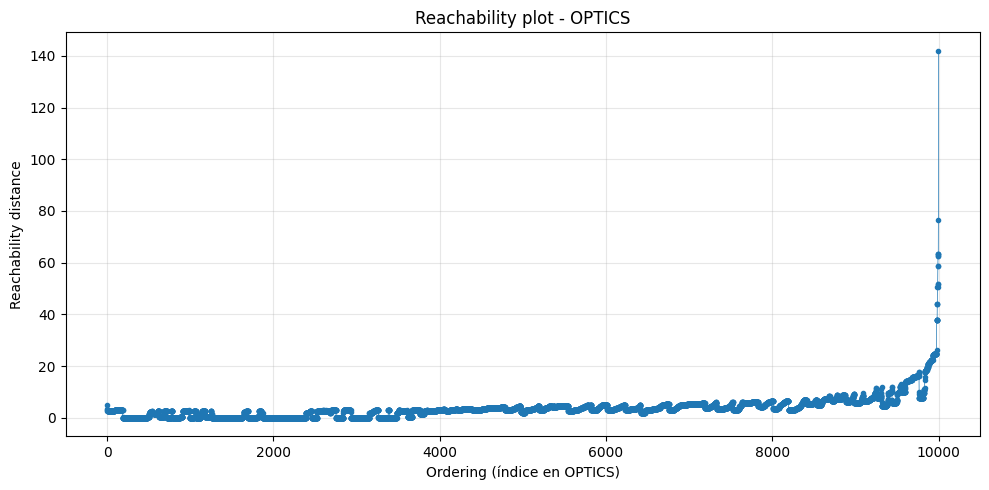

In [46]:
import matplotlib.pyplot as plt

space = np.arange(len(X_opt))

plt.figure(figsize=(10, 5))
plt.plot(space, reachability[ordering], marker='.', linestyle='-', linewidth=0.5)
plt.xlabel("Ordering (índice en OPTICS)")
plt.ylabel("Reachability distance")
plt.title("Reachability plot - OPTICS")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [47]:
from sklearn.cluster import cluster_optics_dbscan
from sklearn.metrics import silhouette_score
import pandas as pd

eps_values = [0.5, 1.0, 1.5, 2.0]   # ejemplo, ajústalo según el scale de tu X_pca

resultados_eps = []

for eps in eps_values:
    labels_db = cluster_optics_dbscan(
        reachability=optics.reachability_,
        core_distances=optics.core_distances_,
        ordering=optics.ordering_,
        eps=eps
    )

    mask_core = labels_db != -1
    n_clusters = len(set(labels_db[mask_core]))
    prop_ruido = 1.0 - mask_core.mean()

    if n_clusters >= 2 and mask_core.sum() > 50:
        sil = silhouette_score(X_opt[mask_core], labels_db[mask_core])
    else:
        sil = np.nan

    resultados_eps.append({
        "eps": eps,
        "n_clusters": n_clusters,
        "prop_ruido": prop_ruido,
        "silhouette": sil
    })

resultados_optics_db = pd.DataFrame(resultados_eps)
print(resultados_optics_db)


   eps  n_clusters  prop_ruido  silhouette
0  0.5          16      0.7616    0.929530
1  1.0          16      0.7578    0.927238
2  1.5          18      0.7449    0.906618
3  2.0          21      0.7338    0.890791


In [48]:
# Inicializa la columna para toda la base
df_work["cluster_OPTICS"] = -1

# Asigna los labels de la submuestra
df_work.loc[df_work.index[idx_opt], "cluster_OPTICS"] = labels_opt
df_work["cluster_OPTICS"] = df_work["cluster_OPTICS"].astype(int)

print(df_work["cluster_OPTICS"].value_counts())


cluster_OPTICS
-1    140584
 0       571
Name: count, dtype: int64


In [50]:
tabla_serv_opt = (
    df_work[df_work["cluster_OPTICS"] >= 0]
    .groupby(["cluster_OPTICS", "Servicio"])
    .size()
    .reset_index(name="n")
)

tabla_serv_opt["prop"] = (
    tabla_serv_opt.groupby("cluster_OPTICS")["n"]
    .transform(lambda x: x / x.sum())
)

tabla_serv_opt.sort_values(["cluster_OPTICS", "prop"], ascending=[True, False]).groupby(
    "cluster_OPTICS"
).head(5)


,cluster_OPTICS,Servicio,n,prop
0,0,Ginecobstetricia,521,0.912434
1,0,Hospitalización adultos,50,0.087566


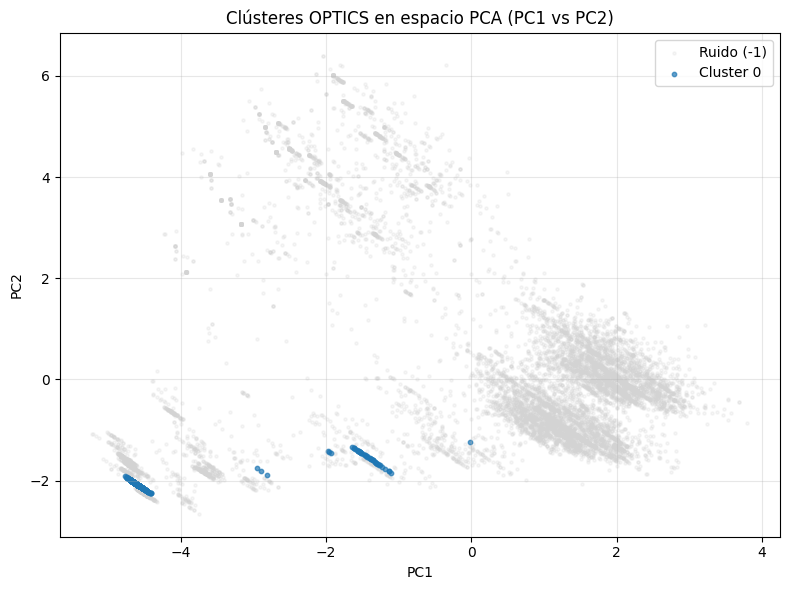

In [51]:
import numpy as np
import matplotlib.pyplot as plt

labels = labels_opt

mask_noise = (labels == -1)
mask_cluster = (labels != -1)

plt.figure(figsize=(8, 6))

# Ruido en gris
plt.scatter(
    X_opt[mask_noise, 0], X_opt[mask_noise, 1],
    s=5, alpha=0.2, color="lightgray", label="Ruido (-1)"
)

# Clústeres
for cl in sorted(np.unique(labels[mask_cluster])):
    mask = (labels == cl)
    plt.scatter(
        X_opt[mask, 0], X_opt[mask, 1],
        s=10, alpha=0.7, label=f"Cluster {cl}"
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clústeres OPTICS en espacio PCA (PC1 vs PC2)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


vamos a mirar como son esos 16 clusters

In [52]:
from sklearn.cluster import cluster_optics_dbscan

eps = 1.0
labels_db = cluster_optics_dbscan(
    reachability=optics.reachability_,
    core_distances=optics.core_distances_,
    ordering=optics.ordering_,
    eps=eps
)


In [53]:
import numpy as np

mask_core = labels_db != -1
X_core = X_opt[mask_core]
labels_core = labels_db[mask_core]

micro_clusters = np.unique(labels_core)  # ej: [0,1,...,15]

centroids = np.array([
    X_core[labels_core == c].mean(axis=0)
    for c in micro_clusters
])
print("Shape centroids:", centroids.shape)  # (n_micro, n_comp_PCA)


Shape centroids: (16, 61)


In [54]:
from sklearn.cluster import AgglomerativeClustering

n_macro = 4

agg = AgglomerativeClustering(
    n_clusters=n_macro,
    linkage="ward"
)
macro_labels_centroids = agg.fit_predict(centroids)

# Mapeo micro -> macro
micro_to_macro = dict(zip(micro_clusters, macro_labels_centroids))
micro_to_macro


{np.int64(0): np.int64(0),
 np.int64(1): np.int64(0),
 np.int64(2): np.int64(2),
 np.int64(3): np.int64(0),
 np.int64(4): np.int64(2),
 np.int64(5): np.int64(2),
 np.int64(6): np.int64(0),
 np.int64(7): np.int64(0),
 np.int64(8): np.int64(0),
 np.int64(9): np.int64(1),
 np.int64(10): np.int64(1),
 np.int64(11): np.int64(1),
 np.int64(12): np.int64(3),
 np.int64(13): np.int64(1),
 np.int64(14): np.int64(3),
 np.int64(15): np.int64(0)}

In [55]:
# Macro label solo para puntos no ruido
macro_labels_core = np.array([micro_to_macro[c] for c in labels_core])

# Macro labels para todos los puntos de X_opt (incluyendo ruido)
macro_all = np.full_like(labels_db, fill_value=-1)
macro_all[mask_core] = macro_labels_core


In [56]:
# micro y macro para toda la base, inicializados en -1
df_work["cluster_OPTICS_micro"] = -1
df_work["cluster_OPTICS_macro"] = -1

# Asignar en las filas de la submuestra idx_opt
df_work.loc[df_work.index[idx_opt], "cluster_OPTICS_micro"] = labels_db
df_work.loc[df_work.index[idx_opt], "cluster_OPTICS_macro"] = macro_all

df_work["cluster_OPTICS_micro"] = df_work["cluster_OPTICS_micro"].astype(int)
df_work["cluster_OPTICS_macro"] = df_work["cluster_OPTICS_macro"].astype(int)

print(df_work["cluster_OPTICS_micro"].value_counts())
print(df_work["cluster_OPTICS_macro"].value_counts())


cluster_OPTICS_micro
-1     138733
 9        521
 7        384
 0        319
 12       225
 8        133
 3        124
 13       120
 14        90
 11        90
 6         73
 10        64
 1         61
 5         57
 15        57
 4         53
 2         51
Name: count, dtype: int64
cluster_OPTICS_macro
-1    138733
 0      1151
 1       795
 3       315
 2       161
Name: count, dtype: int64


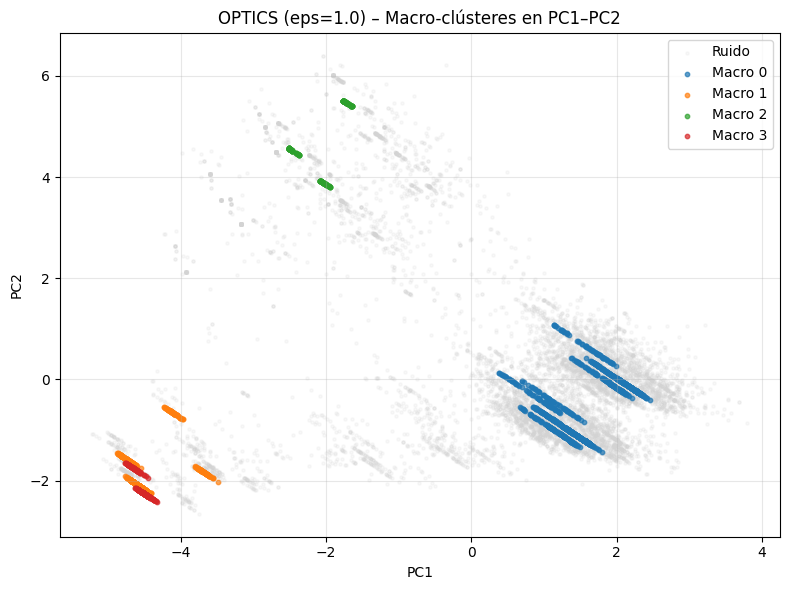

In [57]:
import matplotlib.pyplot as plt

labels_micro = labels_db
labels_macro = macro_all

mask_noise = (labels_micro == -1)
mask_cluster = (labels_micro != -1)

plt.figure(figsize=(8, 6))

# Ruido en gris
plt.scatter(
    X_opt[mask_noise, 0], X_opt[mask_noise, 1],
    s=5, alpha=0.15, color="lightgray", label="Ruido"
)

# Macro-clusters con colores diferentes
for macro in sorted(np.unique(labels_macro[mask_cluster])):
    mask_m = (labels_macro == macro)
    plt.scatter(
        X_opt[mask_m, 0], X_opt[mask_m, 1],
        s=10, alpha=0.7, label=f"Macro {macro}"
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"OPTICS (eps={eps}) – Macro-clústeres en PC1–PC2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [61]:
mapeo = {
    0: 0,  # adultos
    1: 1,  # obstetricia
    2: 2,  # pediatría
    3: 1   # fusionar 3 dentro de 1
}

df_work["cluster_OPTICS_macro2"] = df_work["cluster_OPTICS_macro"].replace(mapeo)

print(df_work["cluster_OPTICS_macro2"].value_counts())


cluster_OPTICS_macro2
-1    138733
 0      1151
 1      1110
 2       161
Name: count, dtype: int64


In [62]:
tabla_serv_macro = (
    df_work[df_work["cluster_OPTICS_macro"] >= 0]
    .groupby(["cluster_OPTICS_macro", "Servicio"])
    .size()
    .reset_index(name="n")
)

tabla_serv_macro["prop"] = (
    tabla_serv_macro.groupby("cluster_OPTICS_macro")["n"]
    .transform(lambda x: x / x.sum())
)

tabla_serv_macro.sort_values(
    ["cluster_OPTICS_macro", "prop"], ascending=[True, False]
).groupby("cluster_OPTICS_macro").head(5)


,cluster_OPTICS_macro,Servicio,n,prop
0,0,Hospitalización adultos,1151,1.0
1,1,Ginecobstetricia,795,1.0
2,2,Hospitalización pediatrica,161,1.0
3,3,Ginecobstetricia,315,1.0


macro 1 y 3 se pueden unir

In [59]:
tabla_edad_macro = (
    df_work[df_work["cluster_OPTICS_macro"] >= 0]
    .groupby(["cluster_OPTICS_macro", "grupo_de_edad"])
    .size()
    .reset_index(name="n")
)

tabla_edad_macro["prop"] = (
    tabla_edad_macro.groupby("cluster_OPTICS_macro")["n"]
    .transform(lambda x: x / x.sum())
)

tabla_edad_macro.sort_values(
    ["cluster_OPTICS_macro", "prop"], ascending=[True, False]
).groupby("cluster_OPTICS_macro").head(5)


,cluster_OPTICS_macro,grupo_de_edad,n,prop
13,0,80 Y MÁS,283,0.245873
12,0,75-79,155,0.134666
11,0,70-74,125,0.108601
10,0,65-69,102,0.088619
9,0,60-64,100,0.086881
17,1,25-29,238,0.299371
16,1,20-24,206,0.259119
18,1,30-34,167,0.210063
19,1,35-39,82,0.103145
15,1,15-19,69,0.086792


In [60]:
tabla_causa_macro = (
    df_work[df_work["cluster_OPTICS_macro"] >= 0]
    .groupby(["cluster_OPTICS_macro", "gran_causa_morbilidad"])
    .size()
    .reset_index(name="n")
)

tabla_causa_macro["prop"] = (
    tabla_causa_macro.groupby("cluster_OPTICS_macro")["n"]
    .transform(lambda x: x / x.sum())
)

tabla_causa_macro.sort_values(
    ["cluster_OPTICS_macro", "prop"], ascending=[True, False]
).groupby("cluster_OPTICS_macro").head(5)


,cluster_OPTICS_macro,gran_causa_morbilidad,n,prop
1,0,Enfermedades no transmisibles,760,0.660295
2,0,Signos y síntomas mal definidos,257,0.223284
0,0,Condiciones transmisibles y nutricionales,134,0.116421
3,1,Condiciones maternas perinatales,795,1.000000
4,2,Condiciones transmisibles y nutricionales,104,0.645963
5,2,Enfermedades no transmisibles,57,0.354037
6,3,Condiciones maternas perinatales,315,1.000000
